# Extra: Estimación de peso y dimensiones de los envíos de Mercado Libre

En este botebook se reproducen los TP2 y TP4 con algunas modificaciones de interés. Se trata de una evolución hacia la solución del problema.

En el caso del TP2 se modifica la construcción de las variables dummy, aplicando OneHotEncoding solo sobre las categorías mas frecuentes.

En el TP4 se explora la transformación previa de las variables cuantitativas tomando logaritmo natural antes de estimar los modelos.

Ambas modificaciones incrementan la performance.

# Materia: Análisis y curación de datos

## Análisis del dataset

Se pide: A partir de lo visto en la teoría de la materia y del segundo laboratorio, diagramar una comunicación en formato textual o interactivo describiendo la solución de las actividades propuestas a continuación. Al final de las mismas se proveen actividades opcionales (no obligatorias) que pueden resultar de interés.

### Actividades Propuestas:
    1.	Eliminar valores cuyo status sea `404` , luego eliminar la columna `status` del dataset ya que solo es útil para limpieza.

    2.	Eliminar los valores NaN de las columnas con prefijo `SHP_`. Estas son aquellas que representan o peso o dimensiones de un item.

    3.	Agrupar por item id y calcular mediana de peso y medidas. De esta forma debería quedar una única fila por cada item_id.

    4.	Parsear la columna de atributos y extraer a columnas propias aquellos atributos cuyo `id` sea `BRAND` o `MODEL`. Estos atributos representan marca o modelo que el vendedor del item ingresó en la publicación. [Opcional] No es necesario limitarse a estos dos atributos, se puede probar quedarse con los N atributos más frecuentes.

    5.	Transformar variables categóricas en números (Se recomienda OneHotEncoding) para las columnas (Sugerencia: arrancar con un sample de ~10K items)

        a.	`CATALOG_PRODUCT_ID`
        b.	`CONDITION`
        c.	`DOMAIN_ID`
        d.	`SELLER_ID`
        e.	`BRAND` (extraída en 4)
        f.	`MODEL`(extraída en 4)

    6.	En caso de tener alguna variable no medida (en nuestro caso `PRICE`) imputar sus valores utilizando kNN.

    7.	Medir las distribuciones de las variables como histogramas, realizar normalizaciones e identificar outliers con los métodos vistos en clase. Hacer análisis de estos outliers y considerar si sería correcto o no eliminarlos del dataset. Sugerencia: Identificar outliers de las columnas `SHP_WEIGHT` y `SHP_VOLUME`, donde `SHP_VOLUME` se define como el producto de las dimensiones.

    8.	[Opcional] Si están interesados en usar texto y técnicas de NLP sobre el título:
        a.	Realizar preprocesamiento del texto, se recomienda leer este artículo.
        b.	Para convertir el título en vectores se recomienda ver tf-idf. wiki, sklearn.

    9.	[Opcional] Aplicar PCA y decidir si existe un subespacio del espacio de features donde viven los datos y son bien descriptos. Graficar.

    10.	[Opcional] Aplicar Mixturas Gaussianas (GMM) para hacer clustering. 

La comunicación debe estar apuntada a un público técnico pero sin conocimiento del tema particular, como por ejemplo, sus compañeros de clase o stakeholders del proyecto. Idealmente, además del documento se debería generar una presentación corta para stakeholders explicando el análisis realizado sobre los datos y las conclusiones obtenidas de tal análisis.

Se evaluarán los siguientes aspectos:

    ●	El informe debe contener un mensaje claro y presentado de forma concisa.
    ●	Los gráficos deben aplicar los conceptos de percepción visual vistos en clase.
    ●	Se debe describir o estimar la significancia estadística de su trabajo.


In [0]:
# pip install scikit-learn


In [0]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import scipy as sc
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import LabelBinarizer
from ast import literal_eval
from pandas.io.json import json_normalize
#import json

#import category_encoders as ce

In [0]:
random.seed(0)

El dataset corresponde a un muestreo de envíos durante tres meses de 2018 en MLB (Mercado Libre Brasil), filtrados según métodos de envíos y por carriers (empresas de correos a cargo del envío propiamente dicho). A su vez, fue muestreado de forma no uniforme para romper de forma manual la distribución de los datos.
Los datos son:[meli_dataset_20190426.csv] (https://drive.google.com/open?id=1tNUKD1lf1z8C7LPpCruiDl6SKBAHb79v).

In [0]:
#DATASET = '../meli_dataset_20190426.csv'

In [0]:
#df_original = pd.read_csv(DATASET, low_memory=False)

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
path = '/content/drive/My Drive/Colab Notebooks/meli_dataset_20190426.csv'
df= pd.read_csv(path)

In [0]:
df

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
0,M1CQ76ZT5W,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN
1,SN7ISIGQ9J,235.0,25.0,25.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-SKIN_CARE_SUPPLIES,68.00,QF4OJMYQ9Q,active,Ácido Hidroquinona 20% 30g + Sabonete Pré Pe...
2,JGEV50GW2U,1757.0,23.0,17.0,16.0,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",YRBDJR6T7Y,new,MLB-NEBULIZERS,145.90,WEE71CZC2Q,active,Inalador E Nebulizador Infantil Nebdog Superfl...
3,JGEV50GW2U,1748.0,23.0,17.0,16.0,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",YRBDJR6T7Y,new,MLB-NEBULIZERS,145.90,WEE71CZC2Q,active,Inalador E Nebulizador Infantil Nebdog Superfl...
4,JGEV50GW2U,NaN,NaN,NaN,NaN,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",YRBDJR6T7Y,new,MLB-NEBULIZERS,145.90,WEE71CZC2Q,active,Inalador E Nebulizador Infantil Nebdog Superfl...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
499943,M07A72S50R,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,YQ7UPVPKB2,under_review,Blusa De Frio Oakley Masculino Jaco Jaqueta Ziper
499944,GQCZ8CAMII,259.0,30.0,20.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN
499945,R0Z8T6FQUP,4500.0,90.0,50.0,20.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-DRYING_RACKS,98.00,RA1HU1QP5K,closed,Varal Dobravel Para Parede
499946,RSUCBZZMC5,650.0,20.0,15.0,10.0,NaN,H53U1H7Q5G,NaN,NaN,NaN,NaN,404,NaN


In [0]:
print(len(df.index))

499948


In [0]:
#df = df.head(10000)

In [0]:
df.columns

Index(['ITEM_ID', 'SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT',
       'ATTRIBUTES', 'CATALOG_PRODUCT_ID', 'CONDITION', 'DOMAIN_ID', 'PRICE',
       'SELLER_ID', 'STATUS', 'TITLE'],
      dtype='object')

#### ¿Qué significa cada columna?

* ITEM_ID: id unívoco de cada item publicado. (Ofuscado)
* SHP_WEIGHT: peso del paquete informado por el correo.
* SHP_LENGTH: largo del paquete informado por el correo.
* SHP_WIDTH: ancho del paquete informado por el correo.
* SHP_HEIGHT: altura del paquete informado por el correo.
* ATTRIBUTES: atributos como marca y modelo, entre otros, en formato json-lines
* CATALOG_PRODUCT_ID: id del catálogo (ofuscado).
* CONDITION: condición de venta (nuevo o usado).
* DOMAIN_ID: id de la categoría a la que pertenece la publicación.
* PRICE: precio en reales.
* SELLER_ID: id del vendedor (ofuscado).
* STATUS: estado de la publicación (activa, cerrada, pausada, etc.)
* TITLE: título de la publicación.

In [0]:
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,STATUS,TITLE
130539,FORJO3V5UX,106.0,16.0,12.0,6.0,"[{'id': 'APPLICATION_METHOD', 'name': 'Método ...",H53U1H7Q5G,new,MLB-HAIR_EXTENSIONS,155.00,W64NUF8JAO,active,"Cabelos Humano Leves Ondas De 65cm 50 Gramas, ..."
300082,RQ7RQABX4G,1040.0,18.0,17.0,9.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PERFUMES,120.00,BKJJ4NKW4V,paused,Perfume Vòlgere Golden Classics Frete Gratis
413112,YYH0V8FUP5,3100.0,42.0,29.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-FOLDERS_AND_EXPANDING_FILES,70.00,VUWALFCY52,active,Pasta Suspensa Com Haste Plástica Kraft 50 Uni...
236676,N69ATVMWE8,NaN,NaN,NaN,NaN,"[{'id': 'ALPHANUMERIC_MODEL', 'name': 'Modelo ...",G2X7BIY4UX,new,MLB-PRINTERS,1019.90,SBN79T4KRO,paused,"Multifuncional Epson L395, Impressora, Copiado..."
71335,EW4MOSVSDA,NaN,NaN,NaN,NaN,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-HAND_POLISHERS,399.66,F2P6IVHFH7,active,Politriz Profissional Automotiva 1400w Boina 1...


In [0]:
df.dtypes

ITEM_ID                object
SHP_WEIGHT            float64
SHP_LENGTH            float64
SHP_WIDTH             float64
SHP_HEIGHT            float64
ATTRIBUTES             object
CATALOG_PRODUCT_ID     object
CONDITION              object
DOMAIN_ID              object
PRICE                 float64
SELLER_ID              object
STATUS                 object
TITLE                  object
dtype: object

## Actividad 1:

Eliminar valores cuyo status sea `404` , luego eliminar la columna `status` del dataset ya que solo es útil para limpieza.

In [0]:
# df.filter(["STATUS"])!= "404"

df = df[df.STATUS != "404"]
df = df.drop(columns=['STATUS'])
df.sample(5)

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE
225032,ND4T9KTEUT,NaN,NaN,NaN,NaN,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VIDEO_GAME_CONTROLLERS,234.99,VCXRYGHOZ7,Controle Ps4 Camuflado Verde (modelo Novo Cuh-...
316957,L9VIZYK6U1,NaN,NaN,NaN,NaN,NaN,H53U1H7Q5G,NaN,NaN,NaN,EG2E0YU51V,Adaptador Wireless Usb Rede Wifi 600 Mbs
387751,N23F1LM22Y,676.0,28.0,24.0,23.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-CYCLING_HELMETS,100.00,XOB2BMAIVZ,Capacete Bike Infantil Azul Kit Joelheira + Co...
499021,D2Y9XF3FFZ,460.0,16.0,11.0,2.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",NGW4DL1VG6,new,MLB-PERFUMES,110.90,RWASR5N3ZS,Malbec Tradicional - 100ml - Queima Estoque
241358,ML6OW6YN8I,10910.0,45.0,43.0,30.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-PLANTING_KITS,119.99,GQY3OCZ6ER,Promoção Limitador Divisor Grama Com Borda 100...


## Actividad 2:

Eliminar los valores NaN de las columnas con prefijo `SHP_`. Estas son aquellas que representan o peso o dimensiones de un item.

In [0]:
# df = df.dropna(subset=['SHP_WEIGHT'])
# df = df.dropna(subset=['SHP_LENGTH'])
# df = df.dropna(subset=['SHP_WIDTH'])
# df = df.dropna(subset=['SHP_HEIGHT'])

# o bien:
print(len(df.index))
df = df.dropna(subset=['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT'])
print(len(df.index))
df = df.dropna(subset=['ATTRIBUTES'])
print(len(df.index))

#o bien

# df= df.dropna(df.filter(regex ='SHP_'))

#df.sample(3)

421587
296325
261958


## Actividad 3:

Agrupar por item id y calcular mediana de peso y medidas. De esta forma debería quedar una única fila por cada item_id.

In [0]:
# Agrupamos por item_id
df_grouped = df.groupby(['ITEM_ID'], as_index=False).median()
#Ordenamos el dataframe por item_id
df.sort_values('ITEM_ID', inplace = True)
# Eliminamos filas con item_id duplicados
df.drop_duplicates(subset='ITEM_ID', keep=False, inplace=True)
# Actualizamos dataframe original con la mediana de pesos y medidas
df.set_index('ITEM_ID', inplace=True)
df.update(df_grouped.set_index('ITEM_ID', inplace=True))
df.reset_index()

,ITEM_ID,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE
0,A00SG33UIH,2320.0,16.0,11.0,4.0,"[{'id': 'AUTHOR', 'name': 'Autor', 'value_id':...",H53U1H7Q5G,new,MLB-BOOKS,149.99,BCZWFNME44,Apostila Trt-sp 2018 - Analista Jud. Área Apo...
1,A00VIC9XL7,213.0,16.0,13.0,10.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BABY_GROOMING_KITS,329.00,T2JY69NPBA,Wetstop 3 Alarme Miccional Xixi Na Cama Enurese
2,A00VM7MP9F,175.0,25.0,20.0,15.0,"[{'id': 'ITEM_CONDITION', 'name': 'Condição do...",H53U1H7Q5G,new,MLB-BICYCLE_BOTTLE_CAGES,45.00,YA6XOOJU39,Suporte De Garrafa Zefal Wiiz Para Bicicleta
3,A00W1VSE3K,82.0,30.0,15.0,5.0,"[{'id': 'ALARM', 'name': 'Com alarme', 'value_...",H53U1H7Q5G,new,MLB-PEDOMETERS,31.98,DCLDPQAY43,Relógio Marcador De Passos Distancia E Caloria...
4,A011EF73Q1,200.0,16.0,11.0,4.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-VIDEO_GAME_CONTROLLERS,45.90,LV40ZPSGH2,Controle Wii Classic Para Nintendo Wii E Wii U...
...,...,...,...,...,...,...,...,...,...,...,...,...
183106,ZZZ3SAO9N3,2030.0,60.0,40.0,20.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",C2ITARO1L8,new,MLB-HOOKAHS,349.00,OA83VY44FA,Narguile Completo Triton Zip Preto + Rosh Oht ...
183107,ZZZMIXSNBZ,8030.0,52.0,52.0,23.0,"[{'id': 'AMBIENTS', 'name': 'Ambientes', 'valu...",H53U1H7Q5G,new,MLB-CEILING_LIGHTS,759.99,K31Y95U41G,Lustre Cristal Âmbar 8 Lampadas Velas E-14 In...
183108,ZZZOE5LENH,876.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-CLOTHING,129.90,PR7Y1SV4UX,4 Cinta Modeladora Feminina Slimbelt Afina Cin...
183109,ZZZWGDHGBS,1190.0,33.0,26.0,17.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-KITCHEN_SUPPLIES,35.10,TT033J01O3,Revisteiro De Chão Porta Revista Modelo Luxo C...


## Actividad 4:

Parsear la columna de atributos y extraer a columnas propias aquellos atributos cuyo `id` sea `BRAND` o `MODEL`. Estos atributos representan marca o modelo que el vendedor del item ingresó en la publicación. [Opcional] No es necesario limitarse a estos dos atributos, se puede probar quedarse con los N atributos más frecuentes.

In [0]:
def attribute_to_list(attribute):
    if attribute:
        return literal_eval(attribute)
    else:
        return []

In [0]:
#df['temporal']=""
#for x in range(len(df.index)):
#for x in range(len(df.index)):
#    if df["ATTRIBUTES"][x]=='[]':
#        df['temporal'][x]= "NADA"
#    else:
#        temp = json_normalize(attribute_to_list(df["ATTRIBUTES"][x]))
#        df['temporal'][x]=temp['value_name'][temp['id']=='BRAND'].copy()
    

In [0]:
l = []
for x in range(len(df.index)):
    if df["ATTRIBUTES"][x]=='[]':
        l.append('Series([], )')
    else:
        temp = json_normalize(attribute_to_list(df["ATTRIBUTES"][x]))
        l.append(temp["value_name"][temp["id"]== "BRAND"].to_string())
    

In [0]:
l

['Series([], )',
 '0    Wet Stop',
 '1    zefal',
 '2    BLUELANS',
 '0    Feir',
 '0    Meu Doce Casamento',
 '0    BIOFOCCUS',
 '0    Mvb Modas',
 '0    Ralph Lauren',
 '0    Blitz Feminina',
 '0    Hannamoon',
 '0    Sutia Adesivo Invisivel Levanta E Aumenta Seio...',
 'Series([], )',
 '0    Philips',
 'Series([], )',
 'Series([], )',
 '0    Decalx',
 'Series([], )',
 'Series([], )',
 '1    GM',
 '0    Sevefort',
 '0    Best Press',
 '0    Performance',
 '0    Mor',
 '0    None',
 '0    Xiaomi',
 '0    IN NATURA',
 '3    ECP',
 '0    Macaulay',
 '0    Newracing',
 '1    Originais',
 '0    Sony',
 '0    Flora Nativa',
 '0    Aramados Jomer',
 '1    Samsung',
 '0    Cutter Bowl',
 '0    Airflo',
 '0    2 Canais',
 '0    Eldorado',
 '0    JLATAI',
 '0    DESALFY',
 'Series([], )',
 '0    Catharine Hill',
 'Series([], )',
 '0    Metal PEM',
 '2    Moda Z',
 '0    LG',
 'Series([], )',
 '0    Penks',
 '1    Louis Vuitton',
 '2    Osram',
 '1    None',
 '0    Imper',
 '0    Vonder',
 '1  

In [0]:
df["BRAND"] = np.array(l)


In [0]:
#Eliminación de marca Series([], )
df= df[df["BRAND"]!= "Series([], )"]

In [0]:
l = []
for x in range(len(df.index)):
    if df["ATTRIBUTES"][x]=='[]':
        l.append('Series([], )')
    else:
        temp = json_normalize(attribute_to_list(df["ATTRIBUTES"][x]))
        l.append(temp["value_name"][temp["id"]== "MODEL"].to_string())
    

In [0]:
df["MODELO"] = l

In [0]:
# Eliminación de modelo Series([], )
df= df[df["MODELO"]!= "Series([], )"]



In [0]:
len(df.index)

124927

In [0]:
df2=df.copy()

In [0]:
df=df2.sample(10000)
df

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE,BRAND,MODELO
ITEM_ID,,,,,,,,,,,,,
ZY2ZPFXXN2,14760.0,40.0,27.0,26.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-FUEL_FILTERS,107.00,GWJM2I169T,Óleo Para Motor Mobil Delvac 5w30 Mx Ld Sintét...,0 Tecfil,3 mobil delvac
QFMPQ9J17F,1250.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BEDDING,38.48,X45SXEZA9E,Capa Colchão Solteiro Antiácaro Com Zíper + Ca...,0 Vida Pratika,2 None
XMCF8J9UGC,80.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BRAS,36.37,U8OFR97Q44,Sutiã Modelador Abertura Frontal Plus Reforçad...,0 MiaBr Lingerie,1 abertura frontal
WMPB492KJJ,486.0,30.0,20.0,15.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BOOTS_AND_BOOTIES,54.90,DUFC84L3MP,Bota Infantil Menina Cano Longo Com Fivela Mac...,0 Grugui,6 Bota Feminina Infantil
USAHL9FR15,480.0,16.0,11.0,2.0,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",E98WI5NXQM,new,MLB-ELECTRIC_AIR_PUMPS,58.00,O07R5YSL32,Inflador Bomba Ar Eletrico Colchão Inflável Pi...,1 Western,3 INFLADOR ELÉTRICO
...,...,...,...,...,...,...,...,...,...,...,...,...,...
NV293QILSR,520.0,20.0,20.0,20.0,"[{'id': 'BALLASTS_TYPE', 'name': 'Tipo de reat...",H53U1H7Q5G,new,MLB-XENON_KITS,124.99,XR0A8G25DS,Kit Xenon Corsa 1994 A 2001 H4/2 8000k,2 RayX,8 H4 - 2
Z3HGM4F2G2,1060.0,33.0,27.0,11.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-FOOTWEAR,89.90,OSKEH19M89,Sapato Social Masculino Em Couro Com Cadarço P...,0 Pierutti,5 Sapato Social Masculino - Sapato Social M...
EOPJ5MN84D,1500.0,35.0,35.0,20.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,NaN,120.00,SHCBB50KFX,Rede Camuflagem Militar Airsoft Ghillie. (roup...,0 EMS Company Group,3 Nylon


## Actividad 5:

Transformar variables categóricas en números (Se recomienda OneHotEncoding) para las columnas (Sugerencia: arrancar con un sample de ~10K items)

In [0]:
df.sample(2)
# luego agregar las variables generadas a partir de atributes

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE,BRAND,MODELO
ITEM_ID,,,,,,,,,,,,,
RHT5Z7C844,750.0,16.0,11.0,2.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-LIGHT_BULBS,24.01,FSL25ZACM2,Led Tubular T5 60cm C/calha Acoplada Completa 10w,0 Importado,7 t5
AO42QWMTL9,1500.0,25.0,15.0,10.0,"[{'id': 'BRAND', 'name': 'Marca da fonte', 'va...",H53U1H7Q5G,new,MLB-DESKTOP_COMPUTER_POWER_SUPPLIES,72.99,WOGYNX1EDU,Fonte Desktop 350w Reais 2x Sata 2x Ide Lebo K...,0 lebo,7 Fonte Desktop 350w Reais 2x Sata 2x Ide L...


In [0]:
# Exploración de cantidad de categorías distintas
print(pd.DataFrame(df.CATALOG_PRODUCT_ID.unique()).count())
print(pd.DataFrame(df.CONDITION.unique()).count())
print(pd.DataFrame(df.DOMAIN_ID.unique()).count())
print(pd.DataFrame(df.SELLER_ID.unique()).count())
print(pd.DataFrame(df.TITLE.unique()).count())
print(pd.DataFrame(df.BRAND.unique()).count())
print(pd.DataFrame(df.MODELO.unique()).count())

0    1197
dtype: int64
0    3
dtype: int64
0    1438
dtype: int64
0    7004
dtype: int64
0    9980
dtype: int64
0    6267
dtype: int64
0    9429
dtype: int64


TITLE tiene demasiados valores distintos.
CONDITION y DOMAIN_ID son las mas aptas por cantidad de categorías.
Para CATALOG_PRODUCT_ID, SELLER_ID, BRAND y MODELO veamos información mas detallada:

In [0]:
len(df.index)

10000

In [0]:
df['CATALOG_PRODUCT_ID'].value_counts().head(5)

H53U1H7Q5G    8693
V6IPG9TCA6       7
IC2SI844KS       6
GJE2J3RU4F       4
SNP7TNVKYI       4
Name: CATALOG_PRODUCT_ID, dtype: int64

Una categoría tiene demasiadas repeticiones.

In [0]:
df['CONDITION'].value_counts().head(5)

new              9948
used               38
not_specified      14
Name: CONDITION, dtype: int64

In [0]:
df['DOMAIN_ID'].value_counts().head(5)

MLB-VEHICLE_ACCESSORIES                            161
MLB-HOME_APPLIANCES_ACCESSORIES_AND_SPARE_PARTS    143
MLB-BACKPACKS                                      133
MLB-CELLPHONE_COVERS                               132
MLB-KITCHEN_SUPPLIES                               125
Name: DOMAIN_ID, dtype: int64

In [0]:
df['SELLER_ID'].value_counts().head(5)

XU025K2P1N    16
XYDSNCU3UV    15
O07R5YSL32    15
FPP4RBSNBJ    14
RM0FXFH1FG    13
Name: SELLER_ID, dtype: int64

Muchos valores distintos, de los cuales se puede emplear los mas frecuentes.

In [0]:
df['TITLE'].value_counts().head(5)

Cooler Duplo Dual Fan Cpu Pc Intel Amd 775 1150 1151 Am3+     2
Hd 1tb Seagate Notebook Ultrabook 1000gb 7mm 128mb Ps3 Ps4    2
Kit 12 Ventosas + Bomba Ventosaterapia Massoterapia Chines    2
Mesa X1 Articulada P/ Notebook Tablet Ipad C/ Mousepad        2
Hd Externo 1tb Seagate Expansion 1 Tb                         2
Name: TITLE, dtype: int64

In [0]:
df['BRAND'].value_counts().head(5)

0    Importado     192
0    Samsung        77
0    None           72
1    Importado      57
0    Volkswagen     46
Name: BRAND, dtype: int64

Muchos valores distintos, de los cuales se pueden emplear los mas frecuentes. Muchos faltantes.

In [0]:
df['MODELO'].value_counts().head(20)

3    None                           24
5    None                           15
4    None                           14
8    None                           14
6    None                           10
4    Body                            8
7    None                            8
1    Canguru                         7
5    Camiseta                        7
4    Universal                       7
5    EVA - DE ENCAIXE                7
4    01                              7
8    Infantil                        6
5    Importado                       6
5    Sapatilha                       6
5    Casual                          6
5    Shaggy                          6
2    None                            6
6    Calota Centro Miolo de Roda     5
6    Chromecast (2nd Generation)     5
Name: MODELO, dtype: int64

Muchos valores distintos, de los cuales se pueden emplear los mas frecuentes. Demasiados faltantes.

In [0]:
df['MODELO'].value_counts().iloc[10:]

5    EVA - DE ENCAIXE    7
4    01                  7
8    Infantil            6
5    Importado           6
5    Sapatilha           6
                        ..
1    Rendado             1
3    TL-002              1
3    cabo de força       1
9    Redondo             1
6    Mullet Babado       1
Name: MODELO, Length: 9419, dtype: int64

In [0]:
column = "CONDITION"
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
CONDITION_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
CONDITION_ENCODED

,CONDITION_new,CONDITION_not_specified,CONDITION_used
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
9995,1,0,0
9996,1,0,0
9997,1,0,0
9998,1,0,0


In [0]:
#column = 'DOMAIN_ID'
#lb = LabelBinarizer()
#lb_results = lb.fit_transform(df[column].astype(str))
#DOMAIN_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
#DOMAIN_ID_ENCODED.sample(5)

In [0]:
column = 'DOMAIN_ID'
for x in range(len(df.index)):
    if not df[column][x] in (df[column].value_counts().iloc[0:99].keys()):
        df[column][x]='Otro'
        
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
DOMAIN_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
DOMAIN_ID_ENCODED.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,DOMAIN_ID_MLB-ALARMS_AND_SENSORS,DOMAIN_ID_MLB-ANIMAL_AND_PET_PRODUCTS,DOMAIN_ID_MLB-ARTS_AND_CRAFTS,DOMAIN_ID_MLB-AUDIO_CABLES,DOMAIN_ID_MLB-AUTOMOTIVE_AMPLIFIERS,DOMAIN_ID_MLB-AUTOMOTIVE_EMBLEMS,DOMAIN_ID_MLB-AUTOMOTIVE_MOLDINGS,DOMAIN_ID_MLB-AUTOMOTIVE_SHOCK_ABSORBERS,DOMAIN_ID_MLB-AUTOMOTIVE_SPEAKERS,DOMAIN_ID_MLB-AUTOMOTIVE_WHEEL_COVERS,DOMAIN_ID_MLB-BABY_SUPPLIES,DOMAIN_ID_MLB-BACKPACKS,DOMAIN_ID_MLB-BED_SHEETS,DOMAIN_ID_MLB-BICYCLE_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-BLOUSES,DOMAIN_ID_MLB-BODY_SKIN_CARE_PRODUCTS,DOMAIN_ID_MLB-BOOTS_AND_BOOTIES,DOMAIN_ID_MLB-CARPETS,DOMAIN_ID_MLB-CAR_SEAT_COVERS,DOMAIN_ID_MLB-CEILING_LIGHTS,DOMAIN_ID_MLB-CELLPHONES,DOMAIN_ID_MLB-CELLPHONE_ACCESSORIES,DOMAIN_ID_MLB-CELLPHONE_AND_TABLET_SCREEN_PROTECTORS,DOMAIN_ID_MLB-CELLPHONE_BATTERIES,DOMAIN_ID_MLB-CELLPHONE_COVERS,DOMAIN_ID_MLB-CELLPHONE_LCD_SCREENS,DOMAIN_ID_MLB-CLOTHING,DOMAIN_ID_MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,DOMAIN_ID_MLB-COMPUTER_MOTHERBOARDS,DOMAIN_ID_MLB-DATA_CABLES,DOMAIN_ID_MLB-DECORATIVE_VINYLS,DOMAIN_ID_MLB-DENTAL_EQUIPMENT,DOMAIN_ID_MLB-DRESSES,DOMAIN_ID_MLB-ELECTRONIC_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-ELECTRONIC_PRODUCTS,DOMAIN_ID_MLB-FANS,DOMAIN_ID_MLB-FISHING_REELS,DOMAIN_ID_MLB-FLOOD_LIGHTS,DOMAIN_ID_MLB-GAME_CONSOLES,DOMAIN_ID_MLB-GAME_CONSOLES_VIDEO_GAMES_AND_ARCADE_MACHINES,...,DOMAIN_ID_MLB-MOTORCYCLE_HELMETS,DOMAIN_ID_MLB-MUSICAL_INSTRUMENT_ACCESSORIES,DOMAIN_ID_MLB-NECKLACES,DOMAIN_ID_MLB-PAINTINGS,DOMAIN_ID_MLB-PANTIES,DOMAIN_ID_MLB-PANTS,DOMAIN_ID_MLB-PARTY_SUPPLIES,DOMAIN_ID_MLB-PHOTOGRAPHY_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-PRINTER_INKS,DOMAIN_ID_MLB-ROUTERS,DOMAIN_ID_MLB-SANDALS_AND_FLIP_FLOPS,DOMAIN_ID_MLB-SHORTS,DOMAIN_ID_MLB-SHOWER_HEADS,DOMAIN_ID_MLB-SKIN_CARE_SUPPLIES,DOMAIN_ID_MLB-SKIRTS,DOMAIN_ID_MLB-SMARTWATCHES,DOMAIN_ID_MLB-SNEAKERS,DOMAIN_ID_MLB-SOUVENIRS,DOMAIN_ID_MLB-SPEAKERS,DOMAIN_ID_MLB-SPORTSWEAR,DOMAIN_ID_MLB-STUFFED_TOYS,DOMAIN_ID_MLB-SUNGLASSES,DOMAIN_ID_MLB-SURVEILLANCE_CAMERAS,DOMAIN_ID_MLB-SWEATSHIRTS_AND_HOODIES,DOMAIN_ID_MLB-TACTICAL_AND_SPORTING_KNIVES_AND_BLADES,DOMAIN_ID_MLB-TONERS,DOMAIN_ID_MLB-TOOLS,DOMAIN_ID_MLB-TOOL_ACCESSORIES_AND_SPARES,DOMAIN_ID_MLB-TOYS_AND_GAMES,DOMAIN_ID_MLB-T_SHIRTS,DOMAIN_ID_MLB-VEHICLE_ACCESSORIES,DOMAIN_ID_MLB-VEHICLE_LED_BULBS,DOMAIN_ID_MLB-VEHICLE_PARTS,DOMAIN_ID_MLB-VIDEO_GAME_CONTROLLERS,DOMAIN_ID_MLB-WALLPAPERS,DOMAIN_ID_MLB-WATER_AND_EXTREME_SPORTS_EQUIPMENT,DOMAIN_ID_MLB-WEDDING_BANDS,DOMAIN_ID_MLB-WINDSHIELD_WIPERS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_Otro
6161,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
392,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8644,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
7251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
6521,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
column = 'SELLER_ID'
for x in range(len(df.index)):
    if not df[column][x] in (df[column].value_counts().iloc[0:99].keys()):
        df[column][x]='Otro'
        
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
#pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_)).head(10)
SELLER_ID_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
SELLER_ID_ENCODED.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,SELLER_ID_AR2IL3B5LS,SELLER_ID_B99Z4JEH95,SELLER_ID_BE2AI2HXRO,SELLER_ID_BLAKIYE3AG,SELLER_ID_CZUSVUMQ8A,SELLER_ID_D78NNMN2B1,SELLER_ID_DPW2B0IWYY,SELLER_ID_DRFAFJCZFH,SELLER_ID_EBB7JBP49T,SELLER_ID_EN9YKXW0T7,SELLER_ID_EWJ84SZBHW,SELLER_ID_F0FOFA3V9E,SELLER_ID_F58FWUVIWA,SELLER_ID_FB7MM6BAJH,SELLER_ID_FDQ5G5EUX3,SELLER_ID_FPP4RBSNBJ,SELLER_ID_FPWS2NLR2C,SELLER_ID_FZKDFHQROF,SELLER_ID_G68LJAR014,SELLER_ID_G69ABY4ZOW,SELLER_ID_GLO0RRGJQ2,SELLER_ID_GN8XX3OXKE,SELLER_ID_GNJE1ZC4X5,SELLER_ID_H1JR93TKLN,SELLER_ID_H5PZUI5M9L,SELLER_ID_H7XU0K6033,SELLER_ID_HRPWQ48T51,SELLER_ID_I2ZAE8HBE4,SELLER_ID_I5RYJENKLK,SELLER_ID_IF28KQP1JK,SELLER_ID_IS817PPN14,SELLER_ID_IT40M3RG6A,SELLER_ID_ITYGN2S4V4,SELLER_ID_IZZ03RKV6N,SELLER_ID_J52JZVH8PH,SELLER_ID_J7KDAXJKJM,SELLER_ID_J906Q9Q2D9,SELLER_ID_JDTJ47GIMF,SELLER_ID_JR85HHQKEY,SELLER_ID_JWHWLHFJK9,...,SELLER_ID_R72KGVLQED,SELLER_ID_RM0FXFH1FG,SELLER_ID_ROVO39AF8Y,SELLER_ID_RV2BHA2VFW,SELLER_ID_S2ADXXFDSX,SELLER_ID_S2BK9FETIU,SELLER_ID_SMGETPBL1E,SELLER_ID_ST5TI53SQB,SELLER_ID_SWV3IAI3TD,SELLER_ID_SX8KCLBPOJ,SELLER_ID_T40HCP9Y27,SELLER_ID_T558M38RGW,SELLER_ID_TAWPQ6BS3Y,SELLER_ID_TG7NL3IU6K,SELLER_ID_TLATNXMN94,SELLER_ID_TYAQEEJ32G,SELLER_ID_U22V5D9EQO,SELLER_ID_UJB567PV4B,SELLER_ID_UTN1QRZ873,SELLER_ID_V4DMXLXD0P,SELLER_ID_V9YPV6322H,SELLER_ID_VK1TI3YFQM,SELLER_ID_VK7YW89LDB,SELLER_ID_VQ3HFM2YHB,SELLER_ID_W1KI1B0PFY,SELLER_ID_W3XL09SHF8,SELLER_ID_WDVQGA2XWU,SELLER_ID_WNONXTQLP7,SELLER_ID_WOGYNX1EDU,SELLER_ID_X6DFMLNJT5,SELLER_ID_X9KP2SRGVR,SELLER_ID_XB9IBIWTFX,SELLER_ID_XMCEIOXA81,SELLER_ID_XMS0O4FRYX,SELLER_ID_XU025K2P1N,SELLER_ID_XYDSNCU3UV,SELLER_ID_Y8P87MXJ8G,SELLER_ID_YJGUQ056YP,SELLER_ID_ZUVVZJOW6S,SELLER_ID_ZXFTE5ZZ00
4645,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3404,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
323,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Title no va, por tener demasiados valores distintos

In [0]:
column = 'BRAND'
for x in range(len(df.index)):
    if not df[column][x] in (df[column].value_counts().iloc[0:99].keys()):
        df[column][x]='Otro'
        
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
BRAND_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
BRAND_ENCODED.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,BRAND_0 3M,BRAND_0 ASUS,BRAND_0 Adidas,BRAND_0 Apple,BRAND_0 Asus,BRAND_0 Black & Decker,BRAND_0 Bomber,BRAND_0 Bosch,BRAND_0 Brother,BRAND_0 Canon,BRAND_0 Casio,BRAND_0 Chevrolet,BRAND_0 Corsair,BRAND_0 Dell,BRAND_0 Diversas,BRAND_0 Eda,BRAND_0 Electrolux,BRAND_0 Epson,BRAND_0 Fiat,BRAND_0 Ford,BRAND_0 Genérico,BRAND_0 HP,BRAND_0 Honda,BRAND_0 IMPORTADA,BRAND_0 IMPORTADO,BRAND_0 Importada,BRAND_0 Importado,BRAND_0 Intelbras,BRAND_0 JBL,BRAND_0 KOMANDANT PARTS,BRAND_0 Kingston,BRAND_0 Knup,BRAND_0 LG,BRAND_0 Lenovo,BRAND_0 Lorben,BRAND_0 Lorenzetti,BRAND_0 Lupo,BRAND_0 Makita,BRAND_0 Melissa,BRAND_0 Microsoft,...,BRAND_0 Shimano,BRAND_0 Sony,BRAND_0 TP-Link,BRAND_0 Taramps,BRAND_0 Techone,BRAND_0 Tomate,BRAND_0 Tramontina,BRAND_0 Universal,BRAND_0 Volkswagen,BRAND_0 Vonder,BRAND_0 Xiaomi,BRAND_0 sem marca,BRAND_1 ASUS,BRAND_1 Acer,BRAND_1 Casio,BRAND_1 Chevrolet,BRAND_1 Dell,BRAND_1 Google,BRAND_1 HP,BRAND_1 Importado,BRAND_1 Intelbras,BRAND_1 LG,BRAND_1 Lenovo,BRAND_1 MOR,BRAND_1 Marine Sports,BRAND_1 Motorola,BRAND_1 None,BRAND_1 Pioneer,BRAND_1 Positivo,BRAND_1 Samsung,BRAND_1 SanDisk,BRAND_1 Seagate,BRAND_1 Sony,BRAND_1 TP-Link,BRAND_1 Volkswagen,BRAND_1 Xiaomi,BRAND_2 Importado,BRAND_2 Samsung,BRAND_2 Seagate,BRAND_Otro
9317,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1755,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
4583,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
8350,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
column = 'MODELO'
for x in range(len(df.index)):
    if not df[column][x] in (df[column].value_counts().iloc[0:99].keys()):
        df[column][x]='Otro'
        
lb = LabelBinarizer()
lb_results = lb.fit_transform(df[column].astype(str))
MODELO_ENCODED = pd.DataFrame(lb_results, columns=(column + '_') + pd.Series(lb.classes_))
MODELO_ENCODED.sample(5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,MODELO_1 Canguru,MODELO_1 Conjunto,MODELO_1 MEIA,MODELO_1 Moletom Canguru,MODELO_1 Outros,MODELO_1 SLIM,MODELO_1 Saída de Maternidade,MODELO_1 Unissex,MODELO_10 Escolar,MODELO_10 None,MODELO_10 Super Frosted,MODELO_10 Trucker,MODELO_12 D250x,MODELO_13 Desktop,MODELO_2 AL,MODELO_2 BORRACHAS DE VEDAÇÃO,MODELO_2 Digital,MODELO_2 IMPORTADO,MODELO_2 Impermeável,MODELO_2 Kit artesanato,MODELO_2 None,MODELO_2 Original,MODELO_2 Quadro abstrato decorativo,MODELO_2 Universal,MODELO_2 Vidro,MODELO_2 mini,MODELO_3 02,MODELO_3 AEROFIT,MODELO_3 Bon Gourmet,MODELO_3 Color 36-200,MODELO_3 Fiesta,MODELO_3 FÊNIX ILUMINAÇÃO,MODELO_3 HP,MODELO_3 Kit,MODELO_3 Longo,MODELO_3 None,MODELO_3 Palio,MODELO_3 Silicone,MODELO_3 Slim,MODELO_3 VW,...,MODELO_6 Social,MODELO_6 Solar,MODELO_6 TL-WR849N,MODELO_6 Tradicional,MODELO_6 Universal,MODELO_7 500ml,MODELO_7 Batman,MODELO_7 H3,MODELO_7 None,MODELO_7 Padrão,MODELO_7 Pn-951,MODELO_7 Q5,MODELO_7 Saída de Maternidade,MODELO_7 Slim,MODELO_7 Soquete,MODELO_7 Tradicional,MODELO_7 Unicornio,MODELO_7 Unicórnio,MODELO_7 pelucia,MODELO_8 Classic,MODELO_8 Cuba de vidro,MODELO_8 Escolar,MODELO_8 Infantil,MODELO_8 Mi Band 2,MODELO_8 Mochila,MODELO_8 None,MODELO_8 Original,MODELO_8 Redondo,MODELO_9 Arandela,MODELO_9 COB 3w,MODELO_9 Caixa de Som,MODELO_9 Hidratante,MODELO_9 Led,MODELO_9 Long Drink,MODELO_9 Milho,MODELO_9 None,MODELO_9 Panela,MODELO_9 Slim,MODELO_9 Verde,MODELO_Otro
1751,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2631,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
9730,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5710,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
5634,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [0]:
#data= df.CATALOG_PRODUCT_ID
#values = np.array(data)
#print(values)
# integer encode
#label_encoder = LabelEncoder()
#integer_encoded = label_encoder.fit_transform(values)
#print(integer_encoded)
# binary encode
#onehot_encoder = OneHotEncoder(sparse=False)
#integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
#onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
#print(onehot_encoded)

In [0]:
df["id"]=CONDITION_ENCODED.index

In [0]:
df=df.set_index("id")

In [0]:
# Adición de las variables generadas por encoding al data frame.

#df = pd.concat([df,CATALOG_PRODUCT_ID_ENCODED, CONDITION_ENCODED, DOMAIN_ID_ENCODED], axis=1)
df = pd.concat([df, CONDITION_ENCODED, DOMAIN_ID_ENCODED], axis=1)

In [0]:
df

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,ATTRIBUTES,CATALOG_PRODUCT_ID,CONDITION,DOMAIN_ID,PRICE,SELLER_ID,TITLE,BRAND,MODELO,CONDITION_new,CONDITION_not_specified,CONDITION_used,DOMAIN_ID_MLB-ALARMS_AND_SENSORS,DOMAIN_ID_MLB-ANIMAL_AND_PET_PRODUCTS,DOMAIN_ID_MLB-ARTS_AND_CRAFTS,DOMAIN_ID_MLB-AUDIO_CABLES,DOMAIN_ID_MLB-AUTOMOTIVE_AMPLIFIERS,DOMAIN_ID_MLB-AUTOMOTIVE_EMBLEMS,DOMAIN_ID_MLB-AUTOMOTIVE_MOLDINGS,DOMAIN_ID_MLB-AUTOMOTIVE_SHOCK_ABSORBERS,DOMAIN_ID_MLB-AUTOMOTIVE_SPEAKERS,DOMAIN_ID_MLB-AUTOMOTIVE_WHEEL_COVERS,DOMAIN_ID_MLB-BABY_SUPPLIES,DOMAIN_ID_MLB-BACKPACKS,DOMAIN_ID_MLB-BED_SHEETS,DOMAIN_ID_MLB-BICYCLE_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-BLOUSES,DOMAIN_ID_MLB-BODY_SKIN_CARE_PRODUCTS,DOMAIN_ID_MLB-BOOTS_AND_BOOTIES,DOMAIN_ID_MLB-CARPETS,DOMAIN_ID_MLB-CAR_SEAT_COVERS,DOMAIN_ID_MLB-CEILING_LIGHTS,DOMAIN_ID_MLB-CELLPHONES,DOMAIN_ID_MLB-CELLPHONE_ACCESSORIES,DOMAIN_ID_MLB-CELLPHONE_AND_TABLET_SCREEN_PROTECTORS,DOMAIN_ID_MLB-CELLPHONE_BATTERIES,...,DOMAIN_ID_MLB-MOTORCYCLE_HELMETS,DOMAIN_ID_MLB-MUSICAL_INSTRUMENT_ACCESSORIES,DOMAIN_ID_MLB-NECKLACES,DOMAIN_ID_MLB-PAINTINGS,DOMAIN_ID_MLB-PANTIES,DOMAIN_ID_MLB-PANTS,DOMAIN_ID_MLB-PARTY_SUPPLIES,DOMAIN_ID_MLB-PHOTOGRAPHY_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-PRINTER_INKS,DOMAIN_ID_MLB-ROUTERS,DOMAIN_ID_MLB-SANDALS_AND_FLIP_FLOPS,DOMAIN_ID_MLB-SHORTS,DOMAIN_ID_MLB-SHOWER_HEADS,DOMAIN_ID_MLB-SKIN_CARE_SUPPLIES,DOMAIN_ID_MLB-SKIRTS,DOMAIN_ID_MLB-SMARTWATCHES,DOMAIN_ID_MLB-SNEAKERS,DOMAIN_ID_MLB-SOUVENIRS,DOMAIN_ID_MLB-SPEAKERS,DOMAIN_ID_MLB-SPORTSWEAR,DOMAIN_ID_MLB-STUFFED_TOYS,DOMAIN_ID_MLB-SUNGLASSES,DOMAIN_ID_MLB-SURVEILLANCE_CAMERAS,DOMAIN_ID_MLB-SWEATSHIRTS_AND_HOODIES,DOMAIN_ID_MLB-TACTICAL_AND_SPORTING_KNIVES_AND_BLADES,DOMAIN_ID_MLB-TONERS,DOMAIN_ID_MLB-TOOLS,DOMAIN_ID_MLB-TOOL_ACCESSORIES_AND_SPARES,DOMAIN_ID_MLB-TOYS_AND_GAMES,DOMAIN_ID_MLB-T_SHIRTS,DOMAIN_ID_MLB-VEHICLE_ACCESSORIES,DOMAIN_ID_MLB-VEHICLE_LED_BULBS,DOMAIN_ID_MLB-VEHICLE_PARTS,DOMAIN_ID_MLB-VIDEO_GAME_CONTROLLERS,DOMAIN_ID_MLB-WALLPAPERS,DOMAIN_ID_MLB-WATER_AND_EXTREME_SPORTS_EQUIPMENT,DOMAIN_ID_MLB-WEDDING_BANDS,DOMAIN_ID_MLB-WINDSHIELD_WIPERS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_Otro
0,14760.0,40.0,27.0,26.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,Otro,107.00,Otro,Óleo Para Motor Mobil Delvac 5w30 Mx Ld Sintét...,Otro,Otro,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,1250.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,Otro,38.48,Otro,Capa Colchão Solteiro Antiácaro Com Zíper + Ca...,Otro,2 None,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,80.0,25.0,25.0,5.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,Otro,36.37,Otro,Sutiã Modelador Abertura Frontal Plus Reforçad...,Otro,Otro,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3,486.0,30.0,20.0,15.0,"[{'id': 'BRAND', 'name': 'Marca', 'value_id': ...",H53U1H7Q5G,new,MLB-BOOTS_AND_BOOTIES,54.90,Otro,Bota Infantil Menina Cano Longo Com Fivela Mac...,Otro,Otro,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,480.0,16.0,11.0,2.0,"[{'id': 'ACCESSORIES_INCLUDED', 'name': 'Acess...",E98WI5NXQM,new,Otro,58.00,O07R5YSL32,Inflador Bomba Ar Eletrico Colchão Inflável Pi...,Otro,Otro,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...

## Actividad 6: 

En caso de tener alguna variable no medida (en nuestro caso `PRICE`) imputar sus valores utilizando kNN.

In [0]:
from fancyimpute import KNN

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
Using TensorFlow backend.


In [0]:
df_numeric = df.select_dtypes([np.number])
df_filled = pd.DataFrame(KNN(3).fit_transform(df_numeric))
#df=df_filled

/usr/local/lib/python3.6/dist-packages/fancyimpute/solver.py:58: UserWarning: Input matrix is not missing any values
  warnings.warn("Input matrix is not missing any values")


Imputing row 1/10000 with 0 missing, elapsed time: 63.416
Imputing row 101/10000 with 0 missing, elapsed time: 63.416
Imputing row 201/10000 with 0 missing, elapsed time: 63.417
Imputing row 301/10000 with 0 missing, elapsed time: 63.417
Imputing row 401/10000 with 0 missing, elapsed time: 63.417
Imputing row 501/10000 with 0 missing, elapsed time: 63.418
Imputing row 601/10000 with 0 missing, elapsed time: 63.418
Imputing row 701/10000 with 0 missing, elapsed time: 63.418
Imputing row 801/10000 with 0 missing, elapsed time: 63.419
Imputing row 901/10000 with 0 missing, elapsed time: 63.419
Imputing row 1001/10000 with 0 missing, elapsed time: 63.419
Imputing row 1101/10000 with 0 missing, elapsed time: 63.420
Imputing row 1201/10000 with 0 missing, elapsed time: 63.420
Imputing row 1301/10000 with 0 missing, elapsed time: 63.421
Imputing row 1401/10000 with 0 missing, elapsed time: 63.421
Imputing row 1501/10000 with 0 missing, elapsed time: 63.421
Imputing row 1601/10000 with 0 missi

In [0]:
df_new = df_filled
#df_nonnumeric = df.select_dtypes(exclude=[np.number])
df_new.columns=df_numeric.columns
df=df_new

## Actividad 7:

Medir las distribuciones de las variables como histogramas, realizar normalizaciones e identificar outliers con los métodos vistos en clase. Hacer análisis de estos outliers y considerar si sería correcto o no eliminarlos del dataset. Sugerencia: Identificar outliers de las columnas `SHP_WEIGHT` y `SHP_VOLUME`, donde `SHP_VOLUME` se define como el producto de las dimensiones.

In [0]:
# creación de la variable SHP_VOLUME
#df["SHP_VOLUME"] = df["SHP_LENGTH"] * df["SHP_WIDTH"] * df["SHP_HEIGHT"]

In [0]:
#df.sample(3)

### Análisis de las distribuciónes de las variables `SHP_WEIGHT` y `SHP_VOLUME`

### `SHP_WEIGHT`

#### Medidas descriptivas

In [0]:
df['SHP_WEIGHT'].describe()

count    10000.000000
mean      1834.025000
std       3227.111448
min          2.000000
25%        250.000000
50%        650.000000
75%       1900.000000
max      42860.000000
Name: SHP_WEIGHT, dtype: float64

#### Boxplot

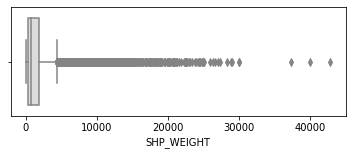

In [0]:
plt.figure(figsize=(6,2))
seaborn.boxplot(x="SHP_WEIGHT", data=df, palette="coolwarm")

#### Coeficientes de asimetría y kurtosis

In [0]:
ku = sc.stats.kurtosis(df["SHP_WEIGHT"])
print('Kurtosis de SHP_WEIGHT: {}'.format(ku))
sw = sc.stats.skew(df["SHP_WEIGHT"])
print('Swewness de SHP_WEIGHT: {}'.format(sw))

Kurtosis de SHP_WEIGHT: 21.819220700791664
Swewness de SHP_WEIGHT: 3.9811809742354187


#### Histograma

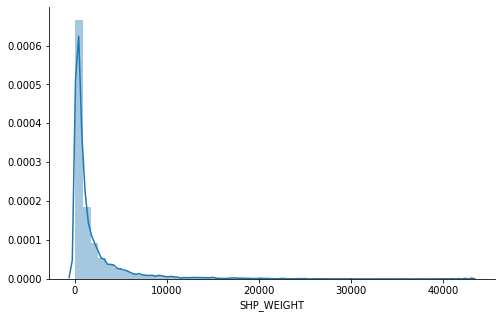

In [0]:
plt.figure(figsize=(8, 5))
seaborn.distplot(df['SHP_WEIGHT'], label='SHP_WEIGHT')
seaborn.despine()

#### Outliers

In [0]:
q1=df["SHP_WEIGHT"].quantile(0.25)
q3=df["SHP_WEIGHT"].quantile(0.75)

LSO = q3 + 1.5 * (q3-q1)
df["SHP_WEIGHT"][df["SHP_WEIGHT"]>LSO]

0       14760.0
8        5820.0
9       15100.0
39       4420.0
42       6260.0
         ...   
9944     4500.0
9947     6250.0
9963    18750.0
9965    12800.0
9982    11560.0
Name: SHP_WEIGHT, Length: 1113, dtype: float64

#### Histograma de los outliers

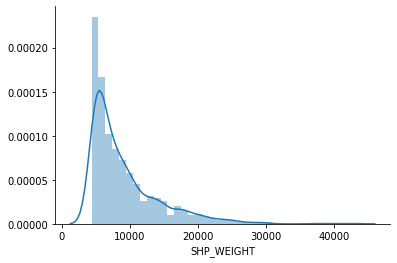

In [0]:
seaborn.distplot(df["SHP_WEIGHT"][df["SHP_WEIGHT"]>LSO])
seaborn.despine()

#### Histograma sin outliers

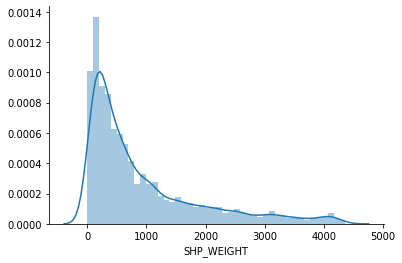

In [0]:
seaborn.distplot(df["SHP_WEIGHT"][df["SHP_WEIGHT"]<=LSO])
seaborn.despine()

#### Histograma del logaritmo natural

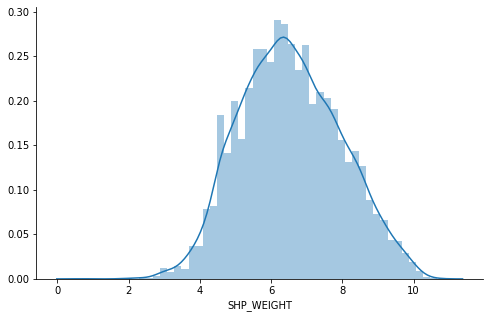

In [0]:
plt.figure(figsize=(8, 5))
seaborn.distplot(np.log(df['SHP_WEIGHT']))
seaborn.despine()

Como el histograma sin outliers aparenta tener nuevamente outliers se aprecia que mas que un probelma de outliers se tienen un problema de distribución de tipo exponencial. Al tomar logaritmo natural se obtiene una distribución bastente bien comportada. En vez de remover outliers conviene transformar la variable tomando su logaritmo natural.

### `SHP_VOLUME`

#### Medidas descriptivas

In [0]:
#df['SHP_VOLUME'].describe()

#### Boxplot

In [0]:
#plt.figure(figsize=(6,2))
#seaborn.boxplot(x="SHP_VOLUME", data=df, palette="coolwarm")

#### Coeficientes de asimetría y kurtosis

In [0]:
#ku = sc.stats.kurtosis(df["SHP_VOLUME"])
#print('Kurtosis de SHP_VOLUME: {}'.format(ku))
#sw = sc.stats.skew(df["SHP_VOLUME"])
#print('Swewness de SHP_VOLUME: {}'.format(sw))

#### Histograma

In [0]:
#plt.figure(figsize=(8, 5))
#seaborn.distplot(df['SHP_VOLUME'], label='SHP_VOLUME')
#seaborn.despine()

#### Outliers

In [0]:
#q1=df["SHP_VOLUME"].quantile(0.25)
#q3=df["SHP_VOLUME"].quantile(0.75)

#LSO = q3 + 1.5 * (q3-q1)
#df["SHP_VOLUME"][df["SHP_VOLUME"]>LSO]

#### Histograma de los outliers

In [0]:
#seaborn.distplot(df["SHP_VOLUME"][df["SHP_VOLUME"]>LSO])
#seaborn.despine()

#### Histograma sin outliers

In [0]:
#seaborn.distplot(df["SHP_VOLUME"][df["SHP_VOLUME"]<=LSO])
#seaborn.despine()

In [0]:
#df['SHP_VOLUME'][df["SHP_VOLUME"] >0]

In [0]:
#len(df['SHP_VOLUME'].index)

In [0]:
#df['SHP_VOLUME'][df["SHP_VOLUME"] ==0]

In [0]:
#df['SHP_VOLUME'][df["SHP_VOLUME"] <0]

#### Histograma del logaritmo natural

En este caso, dado que la variable asume algunos valores nulos se produce un error al tomar logaritmos. Dado que ese problema se da en relativamente pocos valores, se opta por trabajar con el logaritmo natural de los valores no nulos de la variable.

In [0]:
#plt.figure(figsize=(8, 5))
#seaborn.distplot(np.log(df['SHP_VOLUME'][df["SHP_VOLUME"] >0]))
#seaborn.despine()

Como el histograma sin outliers aparenta tener nuevamente outliers se aprecia que mas que un probelma de outliers se tienen un problema de distribución de tipo exponencial. Al tomar logaritmo natural se obtiene una distribución bastente bien comportada. En vez de remover outliers conviene transformar la variable tomando su logaritmo natural.

# TP4 Aprendizaje supervisado

In [0]:
df_tp2=df

In [0]:
SHP_WEIGHT_LOG = np.log(df["SHP_WEIGHT"])

In [0]:
SHP_WEIGHT_LOG.describe()

count    10000.000000
mean         6.546298
std          1.408338
min          0.693147
25%          5.521461
50%          6.476972
75%          7.549609
max         10.665694
Name: SHP_WEIGHT, dtype: float64

In [0]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
import seaborn
import scipy as sc
from math import sqrt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelBinarizer
from ast import literal_eval
from pandas.io.json import json_normalize
from fancyimpute import KNN
#extras para TP4
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error, make_scorer
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor 
#import tensorflow as tf
%matplotlib inline

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(

## Actividad 1  a 3

In [0]:
# división entre instancias y etiquetas

X, y = df.iloc[:, 4:], df[['SHP_WEIGHT', 'SHP_LENGTH', 'SHP_WIDTH', 'SHP_HEIGHT']]

# división entre entrenamiento y evaluación
#stratify=y no se emplea porque no es problema de clasificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
MAE = make_scorer(mean_absolute_error,greater_is_better=False)

### Random Forest Regressor

In [0]:
def random_forest_forecast(X_train,X_test,y_train, y_test):
    
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {'n_estimators': [10,20, 50], 'max_depth':[10,20,50]}
    # 'n_estimators': [1000], 'max_features': [10,15,20,25], 'max_depth':[20,20,25,25,]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=MAE)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Random forest regression...')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train, y_pred_train, multioutput= 'raw_values'))
    print('MAE en test:')
    print(mean_absolute_error(y_test, y_pred, multioutput= 'raw_values'))

In [0]:
random_forest_forecast(X_train,X_test,y_train, y_test)

Random forest regression...
Mejores Parámetros:
{'max_depth': 10, 'n_estimators': 50}
Best CV Score:
390.4964826801747
MAE en entrenamiento:
[1343.46781142   11.63872646    7.65173715    5.92307289]
MAE en test:
[1578.15836734   12.34060132    8.38679162    6.46507988]


El modelo sobreajusta demasiado, porque el desempeño en test es muy inferior al desempeño en la muestra de entrenamiento. Es intrigante que empeora el modelo al seleccionar los hiperparámetos por cross validation ( en el modelo original sin tunear hiperparámetros se tenía un mejor desempeño en test.

### Gradient Boosting Regression

In [0]:
def gradient_boosting_forecast(X_train,X_test,y_train, y_test):
    
    gbr = GradientBoostingRegressor(loss='lad', random_state=5,criterion='mae')
    param_grid = {'n_estimators': [10], 'learning_rate':[0.01,0.1,1,10]}
    # 'n_estimators': [10], 'max_features': [10,15,20,25], 'learning_rate':[0.01,0.1,1,10]}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Gradient boosting regression...')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train, y_pred_train, multioutput= 'raw_values'))
    print('MAE en test:')
    print(mean_absolute_error(y_test, y_pred, multioutput= 'raw_values'))

In [0]:
gradient_boosting_forecast(X_train,X_test,y_train.iloc[:,0], y_test.iloc[:,0])

Gradient boosting regression...
Mejores Parámetros:
{'learning_rate': 1, 'n_estimators': 10}
Best CV Score:
-0.11615663918155002
MAE en entrenamiento:
[1330.4095]
MAE en test:
[1392.1835]


### Red neuronal (MLP)

In [0]:
def multi_layer_perceptron_forecast(X_train,X_test,y_train, y_test):
    
    mlp = MLPRegressor()
    param_grid = {'solver': ['lbfgs'], 'max_iter': [1000 ], 'alpha': 10.0 ** -np.arange(1, 2), 
                  'hidden_layer_sizes':10*np.arange(10, 15), 'random_state':[5]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Multi-layer perceptron regression...')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train, y_pred_train, multioutput= 'raw_values'))
    print('MAE en test:')
    print(mean_absolute_error(y_test, y_pred, multioutput= 'raw_values'))

In [0]:
multi_layer_perceptron_forecast(X_train,X_test,y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Multi-layer perceptron regression...
Mejores Parámetros:
{'alpha': 0.1, 'hidden_layer_sizes': 100, 'max_iter': 1000, 'random_state': 5, 'solver': 'lbfgs'}
Best CV Score:
-0.17716533746630622
MAE en entrenamiento:
[1585.43495532   15.36539159   27.8721327     6.85699505]
MAE en test:
[1597.41861667   15.45750614   27.95169502    7.27981759]


Se tiene un desempeño marcadamente inferior al de las regresiones random forest y gradient boosting. Además es mejor el ajuste en test que en entenamiento. Por lo tanto probablemente se deba probar un arquitectura mas compleja.

# Actividad 4

Elegir el mejor modelo entrenado hasta el momento según f1-score. Comparar las métricas de este modelo vs. las métricas de evaluar 4 modelos por separado, un modelo para cada uno de los targets. Interpretar los resultados. 

No se emplea el f1-score porque no aplica a problemas de regresión. En la actividad 3 se computaron las métricas MAE, para cada uno de los modelos seleccionados, dando mejores resultados la regresión random forest. En esta actividad se agregan las métricas que se obtienen al estimar modelos para cada variable por separado.

## Regresiones con un solo output

### Regresiones random forest con un output

In [0]:
def univariate_random_forest_forecast(X_train,X_test,y_train, y_test):
    
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {'n_estimators': [10,20, 50], 'max_depth':[10,20,50]}
    # 'n_estimators': [1000], 'max_features': [10,15,20,25], 'max_depth':[20,20,25,25,]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=MAE)
    model.fit(X_train, y_train.iloc[:,0])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Random forest regression para SHP_WEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,0], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,0], y_pred))
    
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {'n_estimators': [10,20, 50], 'max_depth':[10,20,50]}
    # 'n_estimators': [1000], 'max_features': [10,15,20,25], 'max_depth':[20,20,25,25,]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=MAE)
    model.fit(X_train, y_train.iloc[:,1])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Random forest regression para SHP_LENGTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,1], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,1], y_pred))
    
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {'n_estimators': [10,20, 50], 'max_depth':[10,20,50]}
    # 'n_estimators': [1000], 'max_features': [10,15,20,25], 'max_depth':[20,20,25,25,]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=MAE)
    model.fit(X_train, y_train.iloc[:,2])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Random forest regression para SHP_WIDTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,2], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,2], y_pred))
    
    rfr = RandomForestRegressor(n_jobs=1, random_state=0)
    param_grid = {'n_estimators': [10,20, 50], 'max_depth':[10,20,50]}
    # 'n_estimators': [1000], 'max_features': [10,15,20,25], 'max_depth':[20,20,25,25,]}
    model = GridSearchCV(estimator=rfr, param_grid=param_grid, n_jobs=1, cv=10, scoring=MAE)
    model.fit(X_train, y_train.iloc[:,3])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Random forest regression para SHP_HEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,3], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,3], y_pred))

In [0]:
univariate_random_forest_forecast(X_train,X_test,y_train, y_test)

Random forest regression para SHP_WEIGHT
Mejores Parámetros:
{'max_depth': 10, 'n_estimators': 50}
Best CV Score:
1535.5320783906325
MAE en entrenamiento:
1343.441569092551
MAE en test:
1578.1123344673533
Random forest regression para SHP_LENGTH
Mejores Parámetros:
{'max_depth': 10, 'n_estimators': 50}
Best CV Score:
12.146861974365128
MAE en entrenamiento:
11.314762457552346
MAE en test:
12.203607319317639
Random forest regression para SHP_WIDTH
Mejores Parámetros:
{'max_depth': 10, 'n_estimators': 50}
Best CV Score:
7.90639638163698
MAE en entrenamiento:
7.5103743642797305
MAE en test:
8.273423508688301
Random forest regression para SHP_HEIGHT
Mejores Parámetros:
{'max_depth': 10, 'n_estimators': 50}
Best CV Score:
6.111296360395656
MAE en entrenamiento:
5.758573488103531
MAE en test:
6.393176623957108


El ajuste de los modelos univariados es mejor que el del modelo multivariante para SHP_WEIGHT y SHP_LENGTH, ocurriendo lo contrario para SHP_WIDTH y SHP_HEIGHT.

### Regresiones gradient boosting con un output

In [0]:
def univariate_gradient_boosting_forecast(X_train,X_test,y_train, y_test):
    
    gbr = GradientBoostingRegressor(loss='lad', random_state=5,criterion='mae')
    param_grid = {'n_estimators': [10], 'learning_rate':[0.01,0.1,1,10]}
    # 'n_estimators': [10], 'max_features': [10,15,20,25], 'learning_rate':[0.01,0.1,1,10]}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,0])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Gradient boosting regression para SHP_WEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,0], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,0], y_pred))
    
    gbr = GradientBoostingRegressor(loss='lad', random_state=5,criterion='mae')
    param_grid = {'n_estimators': [10], 'learning_rate':[0.01,0.1,1,10]}
    # 'n_estimators': [10], 'max_features': [10,15,20,25], 'learning_rate':[0.01,0.1,1,10]}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,1])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Gradient boosting regression para SHP_LENGTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,1], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,1], y_pred))
    
    gbr = GradientBoostingRegressor(loss='lad', random_state=5,criterion='mae')
    param_grid = {'n_estimators': [10], 'learning_rate':[0.01,0.1,1,10]}
    # 'n_estimators': [10], 'max_features': [10,15,20,25], 'learning_rate':[0.01,0.1,1,10]}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,2])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Gradient boosting regression para SHP_WIDTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,2], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,2], y_pred))
    
    gbr = GradientBoostingRegressor(loss='lad', random_state=5,criterion='mae')
    param_grid = {'n_estimators': [10], 'learning_rate':[0.01,0.1,1,10]}
    # 'n_estimators': [10], 'max_features': [10,15,20,25], 'learning_rate':[0.01,0.1,1,10]}
    model = GridSearchCV(estimator=gbr, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,3])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Gradient boosting regression para SHP_HEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,3], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,3], y_pred))

In [0]:
univariate_gradient_boosting_forecast(X_train,X_test,y_train, y_test)

Gradient boosting regression para SHP_WEIGHT
Mejores Parámetros:
{'learning_rate': 1, 'n_estimators': 10}
Best CV Score:
-0.11615663918155002
MAE en entrenamiento:
1330.4095
MAE en test:
1392.1835
Gradient boosting regression para SHP_LENGTH
Mejores Parámetros:
{'learning_rate': 1, 'n_estimators': 10}
Best CV Score:
-0.08039890924272124
MAE en entrenamiento:
11.12085
MAE en test:
11.22025
Gradient boosting regression para SHP_WIDTH
Mejores Parámetros:
{'learning_rate': 1, 'n_estimators': 10}
Best CV Score:
-0.10873134088056972
MAE en entrenamiento:
7.693025
MAE en test:
8.204450000000001
Gradient boosting regression para SHP_HEIGHT
Mejores Parámetros:
{'learning_rate': 1, 'n_estimators': 10}
Best CV Score:
-0.06418861467773042
MAE en entrenamiento:
5.71355
MAE en test:
6.103950000000001


Por lo general es mejor el desempeño de Gradient Boosting que Random Forest. En casi todos los casos tiene mejor ajuste en test y sobrejusta notablemente menos en el conjunto de entrenamiento.

### Regresiones MLP con un output

In [0]:
def univariate_multi_layer_perceptron_forecast(X_train,X_test,y_train, y_test):
    
    mlp = MLPRegressor()
    param_grid = {'solver': ['lbfgs'], 'max_iter': [1000 ], 'alpha': 10.0 ** -np.arange(1, 2), 
                  'hidden_layer_sizes':10*np.arange(10, 15), 'random_state':[5]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,0])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Multi-layer perceptron regression para SHP_WEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,0], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,0], y_pred))
    
    mlp = MLPRegressor()
    param_grid = {'solver': ['lbfgs'], 'max_iter': [1000 ], 'alpha': 10.0 ** -np.arange(1, 2), 
                  'hidden_layer_sizes':10*np.arange(10, 15), 'random_state':[5]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,1])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Multi-layer perceptron regression para SHP_LENGTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,1], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,1], y_pred))
    
    mlp = MLPRegressor()
    param_grid = {'solver': ['lbfgs'], 'max_iter': [1000 ], 'alpha': 10.0 ** -np.arange(1, 2), 
                  'hidden_layer_sizes':10*np.arange(10, 15), 'random_state':[5]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,2])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Multi-layer perceptron regression para SHP_WIDTH')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,2], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,2], y_pred))
    
    mlp = MLPRegressor()
    param_grid = {'solver': ['lbfgs'], 'max_iter': [1000 ], 'alpha': 10.0 ** -np.arange(1, 2), 
                  'hidden_layer_sizes':10*np.arange(10, 15), 'random_state':[5]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=10)
    model.fit(X_train, y_train.iloc[:,3])
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    print('Multi-layer perceptron regression para SHP_HEIGHT')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train.iloc[:,3], y_pred_train))
    print('MAE en test:')
    print(mean_absolute_error(y_test.iloc[:,3], y_pred))

In [0]:
univariate_multi_layer_perceptron_forecast(X_train,X_test,y_train, y_test)

Multi-layer perceptron regression para SHP_WEIGHT
Mejores Parámetros:
{'alpha': 0.1, 'hidden_layer_sizes': 140, 'max_iter': 1000, 'random_state': 5, 'solver': 'lbfgs'}
Best CV Score:
-0.2019853910802843
MAE en entrenamiento:
1594.5392856770277
MAE en test:
1606.116525756082
Multi-layer perceptron regression para SHP_LENGTH
Mejores Parámetros:
{'alpha': 0.1, 'hidden_layer_sizes': 100, 'max_iter': 1000, 'random_state': 5, 'solver': 'lbfgs'}
Best CV Score:
-0.08991747019087222
MAE en entrenamiento:
12.527163465606973
MAE en test:
12.618907211317728
Multi-layer perceptron regression para SHP_WIDTH
Mejores Parámetros:
{'alpha': 0.1, 'hidden_layer_sizes': 100, 'max_iter': 1000, 'random_state': 5, 'solver': 'lbfgs'}
Best CV Score:
-0.10284444568328327
MAE en entrenamiento:
8.111316239837123
MAE en test:
8.482399557700363
Multi-layer perceptron regression para SHP_HEIGHT
Mejores Parámetros:
{'alpha': 0.1, 'hidden_layer_sizes': 140, 'max_iter': 1000, 'random_state': 5, 'solver': 'lbfgs'}
Best C

Las regresiones MLP univariates funcionan un poco mejor que la multivariante (al menos con esta arquitectura secilla).

# Extra: búsqueda de una mejor arquitectura

En las actividades previas se empleó MLP con una sola capa. En este apartado se escribe código para luego (con más poder de cómputo) construir una arquitectura más compleja. Para compensar el problema de carga computacional extra se reducen la cantidad de iteraciones máximas y el parámétro de cross validation.También se usa un único learning rate.

In [0]:
def deep_MLP(X_train,X_test,y_train, y_test):
    
    mlp = MLPRegressor(random_state=5, max_iter=1000, alpha=0.1, solver='adam')
    param_grid = {'hidden_layer_sizes':[(100,50,25), (120,60,30),(50,25,10)]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Multi-layer perceptron regression...')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train, y_pred_train, multioutput= 'raw_values'))
    print('MAE en test:')
    print(mean_absolute_error(y_test, y_pred, multioutput= 'raw_values'))

In [0]:
deep_MLP(X_train,X_test,y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Multi-layer perceptron regression...
Mejores Parámetros:
{'hidden_layer_sizes': (50, 25, 10)}
Best CV Score:
-0.18377409138510087
MAE en entrenamiento:
[1484.25702006   14.31865563    8.50384506    5.9898996 ]
MAE en test:
[1527.87373608   14.27878059    8.98595796    6.29291489]


Esa arquitectura mejora el ajuste de la red, aunque lo mismo sigue siendo inferior al logrado con random forest y gradient boosting.

In [0]:
def deep_MLP(X_train,X_test,y_train, y_test):
    
    mlp = MLPRegressor(random_state=5, max_iter=1000, alpha=0.1, solver='adam')
    param_grid = {'hidden_layer_sizes':[(100,50,25,10), (100,50,25),(100, 75, 50, 25)]}
    model = GridSearchCV(estimator=mlp, param_grid=param_grid,  cv=3)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    
    print('Multi-layer perceptron regression...')
    print('Mejores Parámetros:')
    print(model.best_params_)
    print('Best CV Score:')
    print(-model.best_score_)
    print('MAE en entrenamiento:')
    print(mean_absolute_error(y_train, y_pred_train, multioutput= 'raw_values'))
    print('MAE en test:')
    print(mean_absolute_error(y_test, y_pred, multioutput= 'raw_values'))

In [0]:
deep_MLP(X_train,X_test,y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Multi-layer perceptron regression...
Mejores Parámetros:
{'hidden_layer_sizes': (100, 50, 25, 10)}
Best CV Score:
-0.21018191520698318
MAE en entrenamiento:
[1372.35599583   15.45092236    8.71467808    7.24695086]
MAE en test:
[1437.69498243   15.59128413    9.20753795    7.51100482]


Las nuevas variantes propuestas no superan a la anterior

# Modelos usando transformación logarítmica

In [0]:
SHP_WEIGHT_LOG = np.log(df["SHP_WEIGHT"])
SHP_LENGTH_LOG = np.log(df["SHP_LENGTH"])
SHP_WIDTH_LOG = np.log(df["SHP_WIDTH"])
SHP_HEIGHT_LOG = np.log(df["SHP_HEIGHT"])
PRICE_LOG = np.log(df["PRICE"])

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [0]:
df_2= df.copy()
#df_2=df_2[df2['SHP_WEIGHT']]
df_2 = df_2[(df_2['SHP_WEIGHT']>0) & (df_2['SHP_LENGTH']>0) & (df_2['SHP_WIDTH']>0) & (df_2['SHP_HEIGHT']>0 )].dropna(axis=1)

SHP_WEIGHT_LOG = np.log(df_2["SHP_WEIGHT"])
SHP_LENGTH_LOG = np.log(df_2["SHP_LENGTH"])
SHP_WIDTH_LOG = np.log(df_2["SHP_WIDTH"])
SHP_HEIGHT_LOG = np.log(df_2["SHP_HEIGHT"])
PRICE_LOG = np.log(df_2["PRICE"])

In [0]:

#df_2.replace([np.inf, -np.inf], np.nan).dropna(axis=1)

In [0]:
df_log = pd.concat([SHP_WEIGHT_LOG, SHP_LENGTH_LOG, SHP_WIDTH_LOG, SHP_HEIGHT_LOG, PRICE_LOG, df_2.iloc[:,5:]], axis=1)

In [0]:
df_log.describe()

,SHP_WEIGHT,SHP_LENGTH,SHP_WIDTH,SHP_HEIGHT,PRICE,CONDITION_new,CONDITION_not_specified,CONDITION_used,DOMAIN_ID_MLB-ALARMS_AND_SENSORS,DOMAIN_ID_MLB-ANIMAL_AND_PET_PRODUCTS,DOMAIN_ID_MLB-ARTS_AND_CRAFTS,DOMAIN_ID_MLB-AUDIO_CABLES,DOMAIN_ID_MLB-AUTOMOTIVE_AMPLIFIERS,DOMAIN_ID_MLB-AUTOMOTIVE_EMBLEMS,DOMAIN_ID_MLB-AUTOMOTIVE_MOLDINGS,DOMAIN_ID_MLB-AUTOMOTIVE_SHOCK_ABSORBERS,DOMAIN_ID_MLB-AUTOMOTIVE_SPEAKERS,DOMAIN_ID_MLB-AUTOMOTIVE_WHEEL_COVERS,DOMAIN_ID_MLB-BABY_SUPPLIES,DOMAIN_ID_MLB-BACKPACKS,DOMAIN_ID_MLB-BED_SHEETS,DOMAIN_ID_MLB-BICYCLE_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-BLOUSES,DOMAIN_ID_MLB-BODY_SKIN_CARE_PRODUCTS,DOMAIN_ID_MLB-BOOTS_AND_BOOTIES,DOMAIN_ID_MLB-CARPETS,DOMAIN_ID_MLB-CAR_SEAT_COVERS,DOMAIN_ID_MLB-CEILING_LIGHTS,DOMAIN_ID_MLB-CELLPHONES,DOMAIN_ID_MLB-CELLPHONE_ACCESSORIES,DOMAIN_ID_MLB-CELLPHONE_AND_TABLET_SCREEN_PROTECTORS,DOMAIN_ID_MLB-CELLPHONE_BATTERIES,DOMAIN_ID_MLB-CELLPHONE_COVERS,DOMAIN_ID_MLB-CELLPHONE_LCD_SCREENS,DOMAIN_ID_MLB-CLOTHING,DOMAIN_ID_MLB-COMPUTER_EQUIPMENT_AND_SPARE_PARTS,DOMAIN_ID_MLB-COMPUTER_MOTHERBOARDS,DOMAIN_ID_MLB-DATA_CABLES,DOMAIN_ID_MLB-DECORATIVE_VINYLS,DOMAIN_ID_MLB-DENTAL_EQUIPMENT,...,DOMAIN_ID_MLB-MOTORCYCLE_HELMETS,DOMAIN_ID_MLB-MUSICAL_INSTRUMENT_ACCESSORIES,DOMAIN_ID_MLB-NECKLACES,DOMAIN_ID_MLB-PAINTINGS,DOMAIN_ID_MLB-PANTIES,DOMAIN_ID_MLB-PANTS,DOMAIN_ID_MLB-PARTY_SUPPLIES,DOMAIN_ID_MLB-PHOTOGRAPHY_ACCESSORIES_AND_SPARE_PARTS,DOMAIN_ID_MLB-PRINTER_INKS,DOMAIN_ID_MLB-ROUTERS,DOMAIN_ID_MLB-SANDALS_AND_FLIP_FLOPS,DOMAIN_ID_MLB-SHORTS,DOMAIN_ID_MLB-SHOWER_HEADS,DOMAIN_ID_MLB-SKIN_CARE_SUPPLIES,DOMAIN_ID_MLB-SKIRTS,DOMAIN_ID_MLB-SMARTWATCHES,DOMAIN_ID_MLB-SNEAKERS,DOMAIN_ID_MLB-SOUVENIRS,DOMAIN_ID_MLB-SPEAKERS,DOMAIN_ID_MLB-SPORTSWEAR,DOMAIN_ID_MLB-STUFFED_TOYS,DOMAIN_ID_MLB-SUNGLASSES,DOMAIN_ID_MLB-SURVEILLANCE_CAMERAS,DOMAIN_ID_MLB-SWEATSHIRTS_AND_HOODIES,DOMAIN_ID_MLB-TACTICAL_AND_SPORTING_KNIVES_AND_BLADES,DOMAIN_ID_MLB-TONERS,DOMAIN_ID_MLB-TOOLS,DOMAIN_ID_MLB-TOOL_ACCESSORIES_AND_SPARES,DOMAIN_ID_MLB-TOYS_AND_GAMES,DOMAIN_ID_MLB-T_SHIRTS,DOMAIN_ID_MLB-VEHICLE_ACCESSORIES,DOMAIN_ID_MLB-VEHICLE_LED_BULBS,DOMAIN_ID_MLB-VEHICLE_PARTS,DOMAIN_ID_MLB-VIDEO_GAME_CONTROLLERS,DOMAIN_ID_MLB-WALLPAPERS,DOMAIN_ID_MLB-WATER_AND_EXTREME_SPORTS_EQUIPMENT,DOMAIN_ID_MLB-WEDDING_BANDS,DOMAIN_ID_MLB-WINDSHIELD_WIPERS,DOMAIN_ID_MLB-WRISTWATCHES,DOMAIN_ID_Otro
count,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,...,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000,9728.000000
mean,6.580627,3.378743,2.998284,2.242850,4.621076,0.994860,0.001234,0.003906,0.003598,0.004420,0.004523,0.002981,0.002878,0.003392,0.004934,0.003084,0.004729,0.002981,0.004420,0.013466,0.002467,0.004420,0.004112,0.004317,0.007093,0.002673,0.002673,0.008429,0.008840,0.002262,0.003803,0.004009,0.013158,0.011410,0.003289,0.008738,0.003803,0.002673,0.002056,0.002364,...,0.003906,0.002878,0.004420,0.002981,0.003084,0.005345,0.004215,0.002364,0.002364,0.003906,0.006168,0.002056,0.002673,0.002262,0.002878,0.002673,0.006887,0.003598,0.004831,0.002981,0.002262,0.002262,0.005243,0.004934,0.002262,0.002878,0.010382,0.006887,0.005345,0.009766,0.016139,0.003598,0.007093,0.003187,0.002364,0

In [0]:
# división entre instancias y etiquetas

X, y = df_log.iloc[:, 4:], df_log.iloc[:,0:4]

# división entre entrenamiento y evaluación
#stratify=y no se emplea porque no es problema de clasificación
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [0]:
random_forest_forecast(X_train,X_test,y_train, y_test)

Random forest regression...
Mejores Parámetros:
{'max_depth': 20, 'n_estimators': 50}
Best CV Score:
0.5297743400606482
MAE en entrenamiento:
[0.76784691 0.28272668 0.29934173 0.47594769]
MAE en test:
[0.87313304 0.31473158 0.34137169 0.55161373]


In [0]:
deep_MLP(X_train,X_test,y_train, y_test)

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/base.py:420: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multi

Multi-layer perceptron regression...
Mejores Parámetros:
{'hidden_layer_sizes': (100, 50, 25, 10)}
Best CV Score:
-0.31255308596892667
MAE en entrenamiento:
[0.81907818 0.30823819 0.32177814 0.50408241]
MAE en test:
[0.84634774 0.30840214 0.33020465 0.52027918]


In [0]:
from statistics import median

df_log['SHP_WEIGHT'].median()

6.4967749901858625

En todos los casos los ajustes usando la transformación logarítmica son superiores a los obtenidos sin ditra transformación preia. Esto se deduce al comparar los MAE con la mediana.